# Example
### __Multifold cross-validation for GP regression__

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch 
import gpytorch 
import random

# Import GP cross validation and metrics library
import rapid_models.gp_diagnostics.cv as gp_cv 
import rapid_models.gp_diagnostics.metrics as gp_metrics 

# For GP modelling
from rapid_models.gp_models.templates import ExactGPModel 
from rapid_models.gp_diagnostics.utils.stats import snorm_qq
import rapid_models.gp_models.utils as gputils

# DNV primary colors 
clr = {
    'Sky blue':'#99d9f0',
    'Land green':'#3f9c35',
    'Sea blue':'#003591',
    'Dark blue':'#0f204b',
    'Cyan':'#009fda',
}

First we generate some dummy data

In [20]:
# Generate data
random.seed(42)
torch.manual_seed(42)
np.random.seed(42) 

N_DIM = 2 # the X dimension
N_TRAIN = 12

KER_SCALE_TRUE = 1.0
KER_LENGTHSCALE_TRUE = torch.ones(N_DIM+1)*0.5
KER_LENGTHSCALE_TRUE[-1] = KER_LENGTHSCALE_TRUE[-1]*0.5 # Shorter lengthscale in the t-dimension

N_T_TRAIN = np.random.randint(5, 20, size = N_TRAIN) # Different number of observations in the t-dimension for each observed function 

T_TRAIN = [np.linspace(np.random.uniform(0, 0.1), np.random.uniform(0.9, 1.0), n) for n in N_T_TRAIN]

X_TRAIN = np.array([
    [0.82, 0.88], 
    [0.84, 0.81],
    [0.7, 0.22], 
    [0.2, 0.6]
])
X_TRAIN = np.append(X_TRAIN, np.random.uniform(size = (N_TRAIN-4, N_DIM)), axis = 0)

from_to = [0] + list(N_T_TRAIN.cumsum())
FOLDS_INDICES = [list(range(from_to[i], from_to[i+1])) for i in range(N_TRAIN)]

XT_TRAIN = np.zeros(( N_T_TRAIN.sum(), N_DIM + 1))

XT_TRAIN = np.zeros(( N_T_TRAIN.sum(), N_DIM + 1))

for i in range(N_TRAIN):
    XT_TRAIN[FOLDS_INDICES[i], 0:N_DIM] = X_TRAIN[i]
    XT_TRAIN[FOLDS_INDICES[i], -1] = T_TRAIN[i]

In [21]:
# Define kernel and sample training data
ker = gputils.gpytorch_kernel_Matern(KER_SCALE_TRUE, KER_LENGTHSCALE_TRUE)
K = ker(torch.tensor(XT_TRAIN, dtype=torch.float))
normal_rv = gpytorch.distributions.MultivariateNormal(mean = torch.zeros(K.shape[0]), covariance_matrix = K)

Y_TRAIN = normal_rv.sample() 
YT_TRAIN = [Y_TRAIN[t_idx] for t_idx in FOLDS_INDICES]
pass

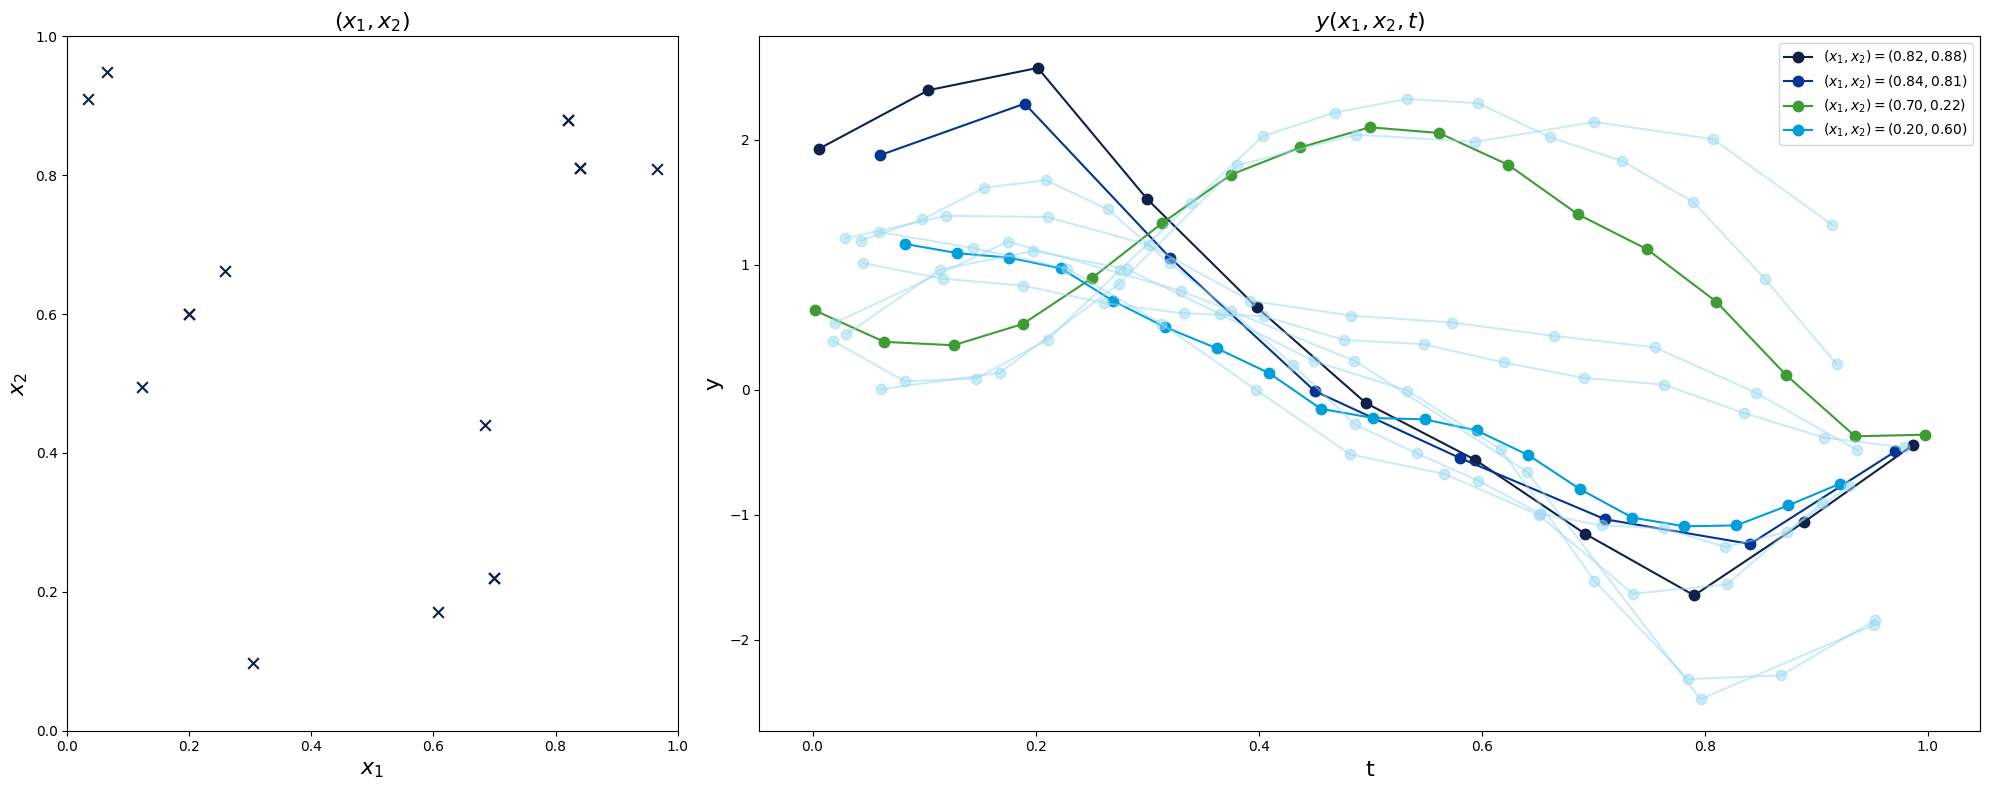

In [22]:
fig, axs = plt.subplots(ncols = 2, figsize = (20, 8), gridspec_kw={'width_ratios': [1, 2]})
axs = axs.ravel() 

# y(t) 
ax = axs[1]
colors = [clr['Dark blue'], clr['Sea blue'], clr['Land green'], clr['Cyan']]
for i in range (4):
    ax.plot(T_TRAIN[i], YT_TRAIN[i], marker = '.', markersize = 15, label = r'$(x_1, x_2) = ({:.2f}, {:.2f})$'.format(X_TRAIN[i][0], X_TRAIN[i][1]), color = colors[i]) 
for i in range (4, N_TRAIN):
    ax.plot(T_TRAIN[i], YT_TRAIN[i], marker = '.', markersize = 15, color = clr['Sky blue'], alpha = 0.5) 

ax.set_xlabel('t', fontsize = 16)
ax.set_ylabel('y', fontsize = 16)
ax.set_title(r'$y(x_1, x_2, t)$', fontsize = 16)
ax.legend()

# x1, x2 - space
ax = axs[0]
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$x_1$', fontsize = 16)
ax.set_ylabel(r'$x_2$', fontsize = 16)
ax.set_title(r'$(x_1, x_2)$', fontsize = 16)

for i in range(4):
    ax.scatter(X_TRAIN[i,0], X_TRAIN[i,1], marker = 'x', s = 60, color = clr['Dark blue'])
ax.scatter(X_TRAIN[:,0], X_TRAIN[:,1], marker = 'x', s = 60, color = clr['Dark blue'])

fig.tight_layout()

## LOO example

## 1) Fit a GP to some data

In [23]:
# Training data 
X_Train = torch.tensor(T_TRAIN[2][::2].reshape(-1, 1), dtype=torch.float)
Y_Train = torch.tensor(YT_TRAIN[2][::2], dtype=torch.float) 

# fig, ax = plt.subplots(figsize = (16, 8))

# ax.plot(X_Train, Y_Train, marker = '.', markersize = 15, color = clr['Dark blue']) 
# ax.set_xlabel('t', fontsize = 16)
# ax.set_ylabel('y', fontsize = 16)
# ax.set_title(r'Training data', fontsize = 16)

C:\Users\claros\AppData\Local\Temp\ipykernel_13264\3369015221.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_Train = torch.tensor(YT_TRAIN[2][::2], dtype=torch.float)


In [24]:
# Fit GP
ker = gputils.gpytorch_kernel_Matern(KER_SCALE_TRUE, KER_LENGTHSCALE_TRUE[-1].reshape(1))
K = ker(X_Train)

model = ExactGPModel(
                X_Train, Y_Train,                                                                   # Training data
                gputils.gpytorch_mean_constant(0.0, fixed = True),                                  # Mean function
                ker,                                                                                # Kernel
                gputils.gpytorch_likelihood_gaussian(variance = 1e-6, fixed = False),               # Likelihood
                '', '') # Name and path for save/load

In [25]:
# Evaluate GP
model.eval_mode()

t = torch.linspace(0, 1, 100).reshape(-1, 1)
m, v = model.predict(t, latent=True, full_cov=True, CG_tol = 0.001)

w, _ = np.linalg.eig(v)
min_eigval = w.min()
print(min_eigval)
jitter = abs(min_eigval*2)
w, _ = np.linalg.eig(v + torch.eye(t.shape[0])*jitter)
print(w.min())

samples = np.array([gpytorch.distributions.MultivariateNormal(m, v + torch.eye(t.shape[0])*jitter).sample().numpy() for _ in range(20)])
pass

(-4.0190486e-07+0j)
(4.0185526e-07+0j)


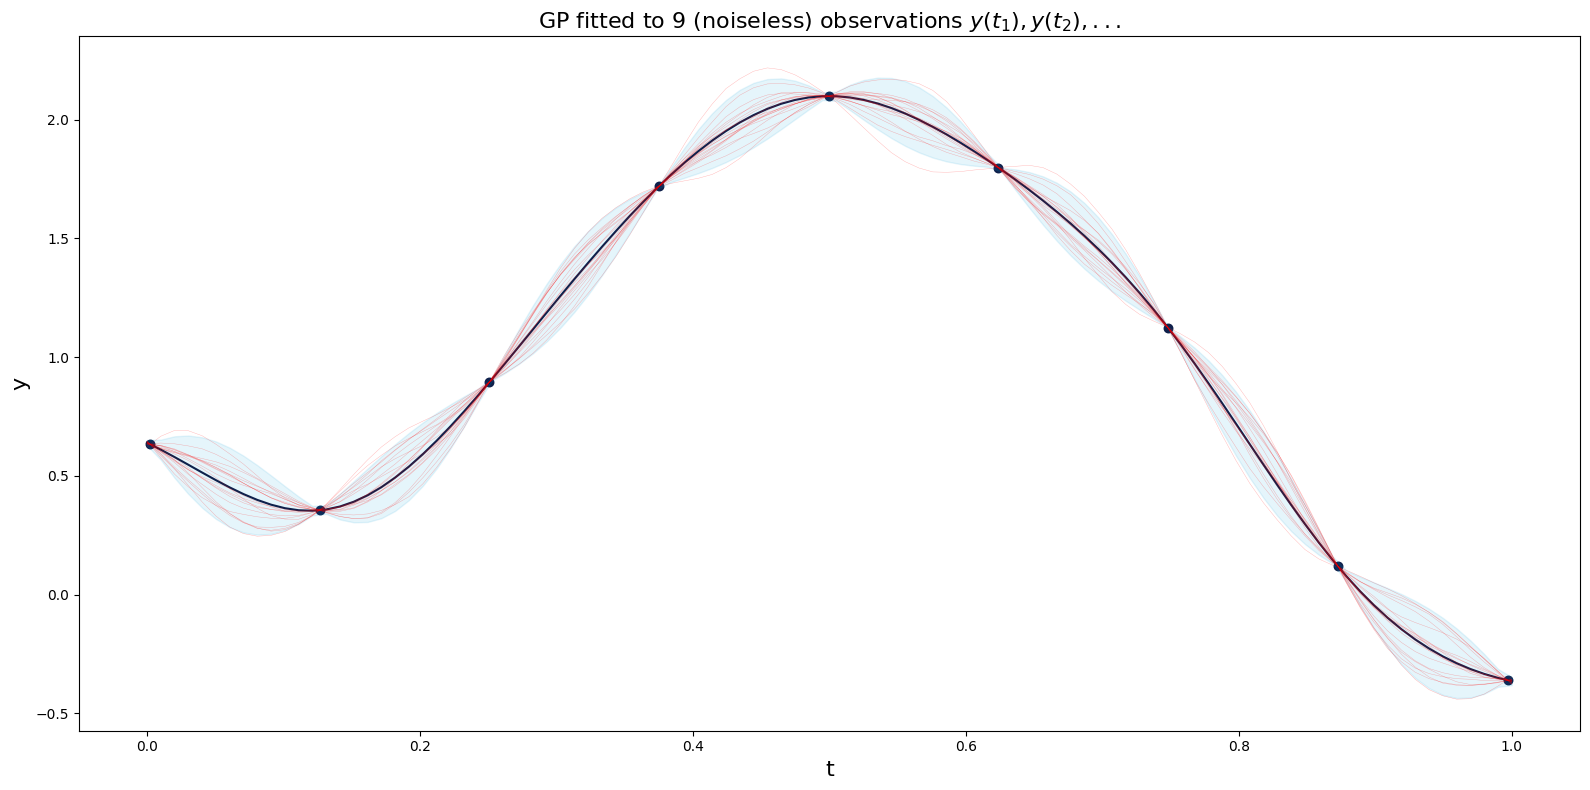

In [26]:
fig, ax = plt.subplots(figsize = (16, 8))

ax.scatter(X_Train, Y_Train, marker = '.', s = 150, color = clr['Dark blue']) 
ax.plot(t.flatten(), m, color = clr['Dark blue'])
ax.fill_between(t.flatten(), m - 2*v.diagonal()**0.5, m + 2*v.diagonal()**0.5, color = clr['Cyan'], alpha = 0.1)
ax.set_xlabel('t', fontsize = 16)
ax.set_ylabel('y', fontsize = 16)
ax.set_title(r'GP fitted to {} (noiseless) observations $y(t_1), y(t_2), ...$'.format(Y_Train.shape[0]), fontsize = 16)

ax.plot(t, samples.T, color = 'red', alpha = 0.3, linewidth = 0.3)
fig.tight_layout()

## 2) Compute LOO errors

In [27]:
# To compute the LOO residuals we only need the covariance matrix and the training observations (converted to numpy arrays)
mean, cov, residuals_transformed = gp_cv.loo(K.numpy(), Y_Train.numpy(), noise_variance = 0) 

# 'residuals_transformed' is the residuals transformed to the standard normal space
# we will see that this is not the same normalizing the individual residuals (which will remain correlated)
residuals_scaled = mean / cov.diagonal()**0.5

In [28]:
# Function for plotting residuals 
def plotres(ax, res, lbl = ''):
    """
    Compute QQ plot of residuals 'res' and plot to ax
    """
    q_sample, q_snorm, q_snorm_upper, q_snorm_lower = snorm_qq(res)
    ax.scatter(q_snorm, q_sample, marker = 'o', facecolors='none', edgecolors='k')
    ax.plot(q_snorm_upper, q_sample, 'k--')
    ax.plot(q_snorm_lower, q_sample, 'k--')
    ax.set_xlabel('Theoretical quantiles')
    ax.set_ylabel('Sample quantiles')
    ax.set_title('Normal Q-Q Plot of {}'.format(lbl))
    line_min = min(q_snorm.min(), q_sample.min())*1.1
    line_max = max(q_snorm.max(), q_sample.max())*1.1
    ax.plot([line_min, line_max], [line_min, line_max], 'k')
    ax.set_xlim(line_min, line_max)
    ax.set_ylim(line_min, line_max)

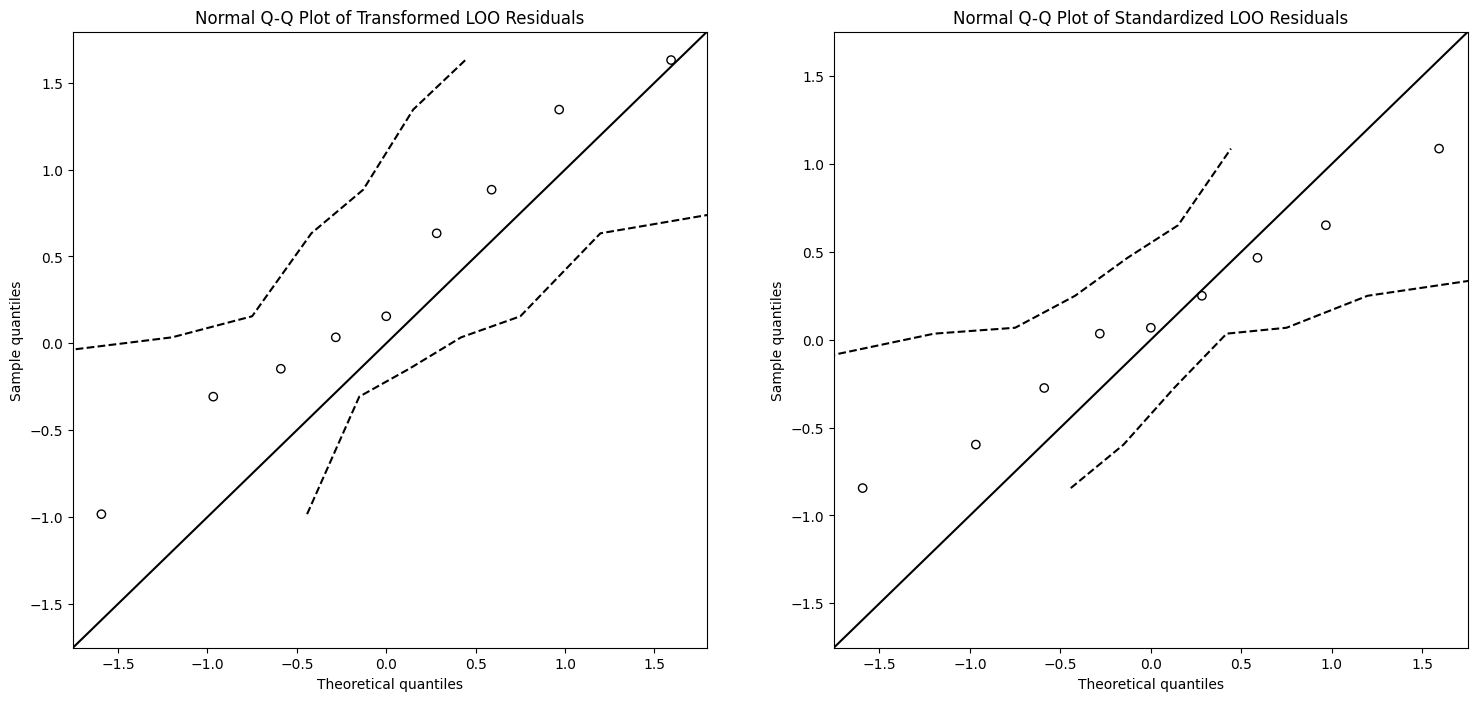

In [29]:
# Plot residuals 
fig, axs = plt.subplots(ncols = 2, figsize = (18, 8))
axs = axs.ravel()

plotres(axs[0], residuals_transformed, 'Transformed LOO Residuals')
plotres(axs[1], residuals_scaled, 'Standardized LOO Residuals')

In [30]:
metrics = gp_metrics.evaluate_GP(K.numpy(), Y_Train.numpy(), noise_variance = 0) 

for key in ['log_marginal_likelihood', 'log_pseudo_likelihood', 'MSE']:
    print(key, metrics[key])

log_marginal_likelihood -5.671192568119462
log_pseudo_likelihood -11.65236669197367
MSE 0.04094600707466854


# Multifold CV example

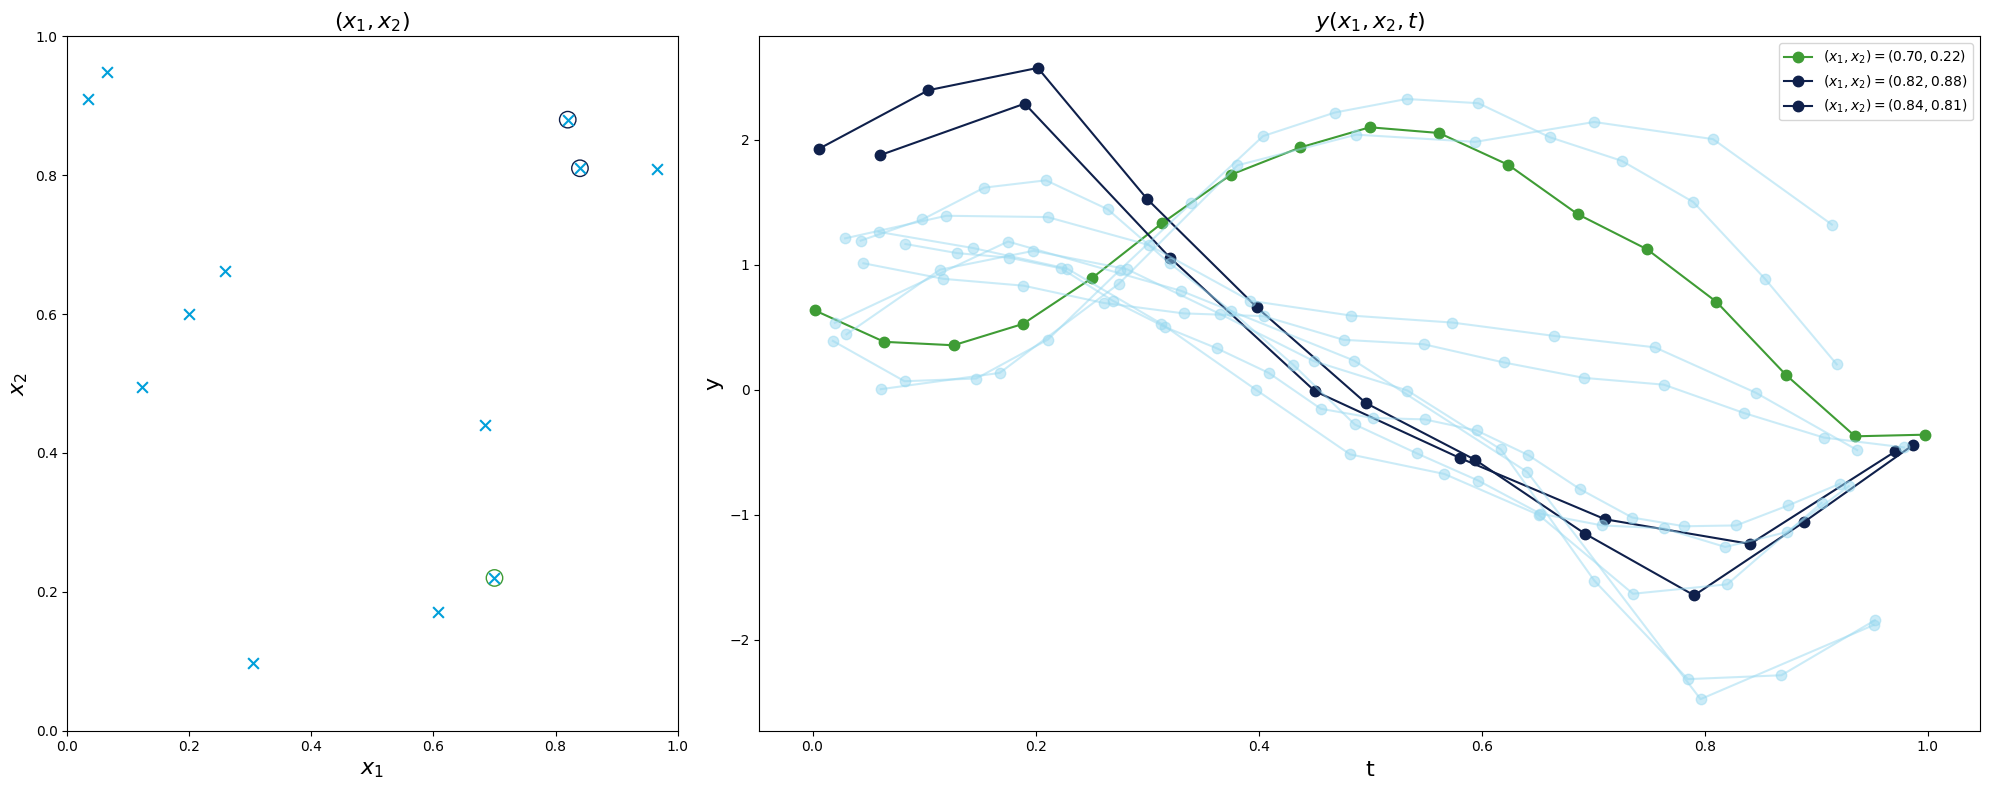

In [31]:
fig, axs = plt.subplots(ncols = 2, figsize = (20, 8), gridspec_kw={'width_ratios': [1, 2]})
axs = axs.ravel() 

# y(t) 
ax = axs[1]
colors = [clr['Dark blue'], clr['Sea blue'], clr['Land green'], clr['Cyan']]
i = 2
ax.plot(T_TRAIN[i], YT_TRAIN[i], marker = '.', markersize = 15, label = r'$(x_1, x_2) = ({:.2f}, {:.2f})$'.format(X_TRAIN[i][0], X_TRAIN[i][1]), color = clr['Land green']) 
for i in [0, 1]:
    ax.plot(T_TRAIN[i], YT_TRAIN[i], marker = '.', markersize = 15, label = r'$(x_1, x_2) = ({:.2f}, {:.2f})$'.format(X_TRAIN[i][0], X_TRAIN[i][1]), color = clr['Dark blue']) 
for i in range (3, N_TRAIN):
    ax.plot(T_TRAIN[i], YT_TRAIN[i], marker = '.', markersize = 15, color = clr['Sky blue'], alpha = 0.5) 

ax.set_xlabel('t', fontsize = 16)
ax.set_ylabel('y', fontsize = 16)
ax.set_title(r'$y(x_1, x_2, t)$', fontsize = 16)
ax.legend()

# x1, x2 - space
ax = axs[0]
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$x_1$', fontsize = 16)
ax.set_ylabel(r'$x_2$', fontsize = 16)
ax.set_title(r'$(x_1, x_2)$', fontsize = 16)

i = 2
ax.scatter(X_TRAIN[i,0], X_TRAIN[i,1], marker = 'o', facecolors='none', edgecolors=clr['Land green'], s = 140)

for i in [0, 1]:
    ax.scatter(X_TRAIN[i,0], X_TRAIN[i,1], marker = 'o', facecolors='none', edgecolors=clr['Dark blue'], s = 140)

ax.scatter(X_TRAIN[:,0], X_TRAIN[:,1], marker = 'x', s = 60, color = clr['Cyan'])

fig.tight_layout()

## 1) Compute GP covariance matrix from tranining inputs 

In [32]:
X_Train = torch.tensor(XT_TRAIN, dtype=torch.float)
Y_Train = torch.tensor(torch.cat(YT_TRAIN), dtype=torch.float) 

ker = gputils.gpytorch_kernel_Matern(KER_SCALE_TRUE, KER_LENGTHSCALE_TRUE)
K = ker(X_Train)
pass

C:\Users\claros\AppData\Local\Temp\ipykernel_13264\3016600905.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_Train = torch.tensor(torch.cat(YT_TRAIN), dtype=torch.float)


## 2) Define folds

In [33]:
# Here, the folds are naturally given from the training data, as a "single observation" corresponds to 
# observing the function y(t), at some some times t_1, t_2, ..., for one specific value of (x_1, x_2)
folds_startstop = np.array([0] + [Y.shape[0] for Y in YT_TRAIN]).cumsum()
folds = [list(range(folds_startstop[i], folds_startstop[i+1])) for i in range(len(folds_startstop)-1)]

print('There are a total of {} folds with the following indices:'.format(len(folds)))
display(folds)


There are a total of 12 folds with the following indices:


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [11, 12, 13, 14, 15, 16, 17, 18],
 [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54],
 [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
 [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81],
 [82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98],
 [99, 100, 101, 102, 103, 104, 105, 106, 107],
 [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118],
 [119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132],
 [133, 134, 135, 136, 137, 138, 139],
 [140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]]

## 3) Compute CV residuals

In [34]:
# To compute the LOO residuals we only need the covariance matrix and the training observations (converted to numpy arrays)
mean, cov, residuals_transformed = gp_cv.multifold(K.numpy(), Y_Train.numpy(), folds, noise_variance = 0) 

# 'residuals_transformed' is the residuals transformed to the standard normal space
# we will see that this is not the same normalizing the individual residuals (which will remain correlated)
residuals_scaled = mean / cov.diagonal()**0.5

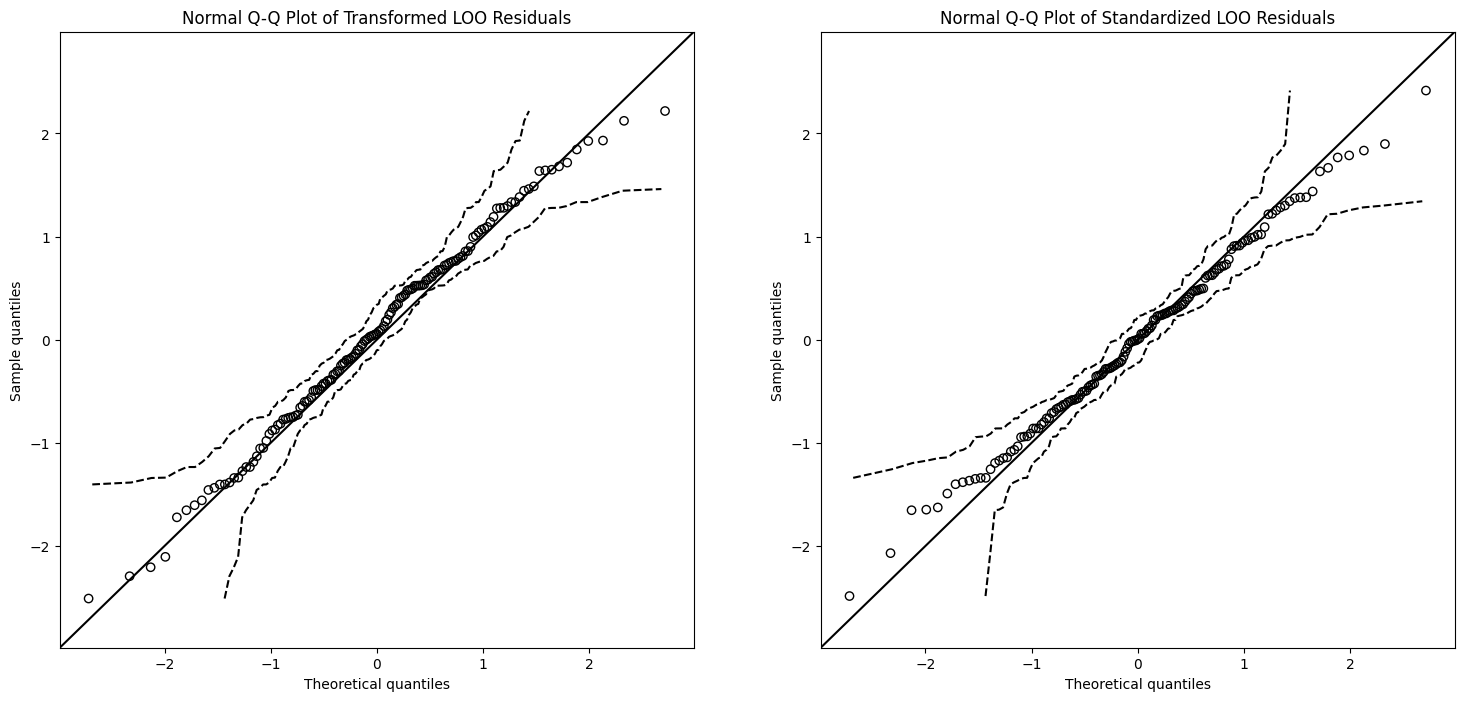

In [35]:
# Plot residuals 
fig, axs = plt.subplots(ncols = 2, figsize = (18, 8))
axs = axs.ravel()

plotres(axs[0], residuals_transformed, 'Transformed LOO Residuals')
plotres(axs[1], residuals_scaled, 'Standardized LOO Residuals')

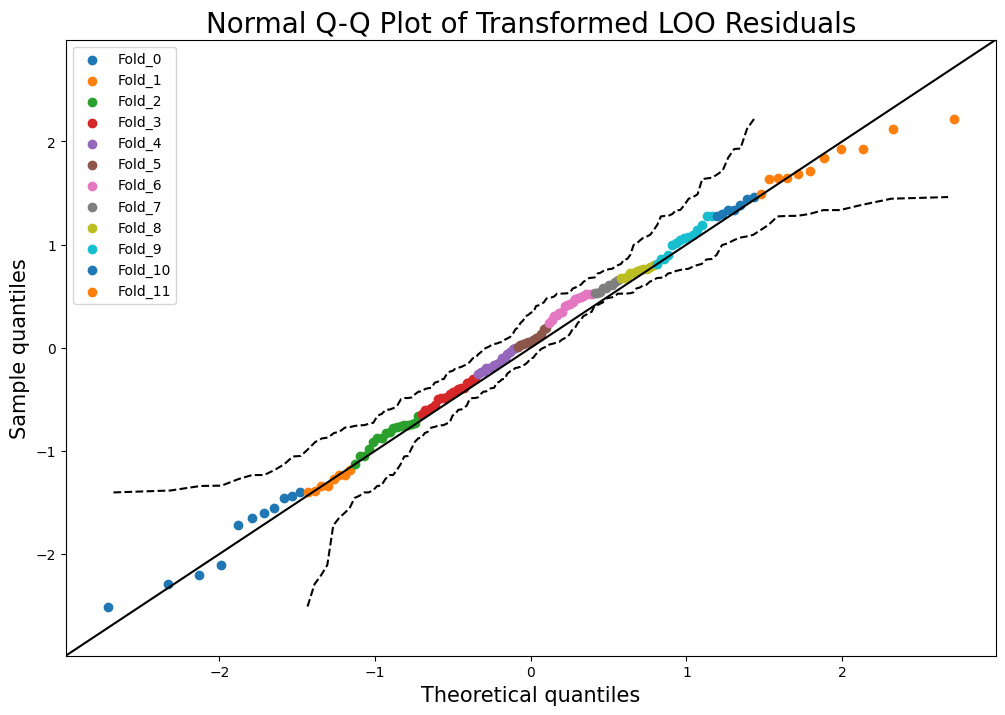

In [36]:
# Color by each fold 
fig, ax = plt.subplots(figsize = (12, 8))

q_sample, q_snorm, q_snorm_upper, q_snorm_lower = snorm_qq(residuals_transformed)
ax.plot(q_snorm_upper, q_sample, 'k--')
ax.plot(q_snorm_lower, q_sample, 'k--')
ax.set_xlabel('Theoretical quantiles', fontsize = 15)
ax.set_ylabel('Sample quantiles', fontsize = 15)
ax.set_title('Normal Q-Q Plot of Transformed LOO Residuals', fontsize = 20)
line_min = min(q_snorm.min(), q_sample.min())*1.1
line_max = max(q_snorm.max(), q_sample.max())*1.1
ax.plot([line_min, line_max], [line_min, line_max], 'k')
ax.set_xlim(line_min, line_max)
ax.set_ylim(line_min, line_max)

for i in range(len(folds)):
    ax.scatter(q_snorm[folds[i]], q_sample[folds[i]], marker = 'o', label = 'Fold_{}'.format(i))

ax.legend()

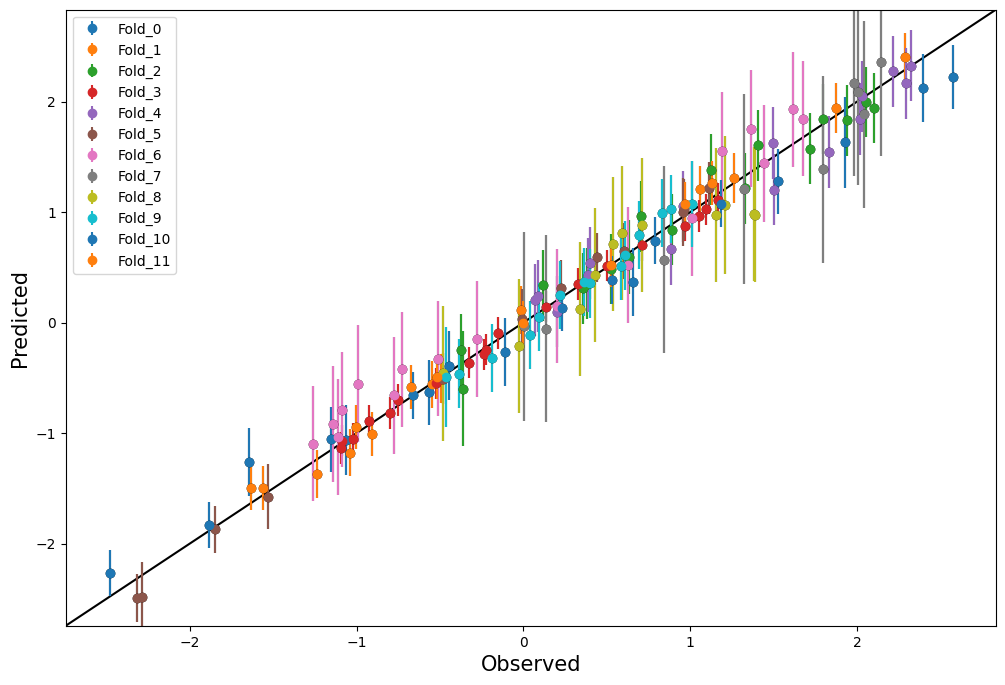

In [37]:
fig, ax = plt.subplots(figsize = (12, 8))

y_obs = Y_Train
y_pred_mean = y_obs - mean
y_pred_std = cov.diagonal()**0.5

ax.set_xlabel('Observed', fontsize = 15)
ax.set_ylabel('Predicted', fontsize = 15)

line_min = min(y_obs.min(), y_pred_mean.min())*1.1
line_max = max(y_obs.max(), y_pred_mean.max())*1.1
ax.plot([line_min, line_max], [line_min, line_max], 'k')
ax.set_xlim(line_min, line_max)
ax.set_ylim(line_min, line_max)

ax.errorbar(y_obs, y_pred_mean, yerr=2*y_pred_std, fmt='o', color = 'k')

for i in range(len(folds)):
    ax.errorbar(y_obs[folds[i]], y_pred_mean[folds[i]], yerr=2*y_pred_std[folds[i]], fmt='o', label = 'Fold_{}'.format(i))

ax.legend()

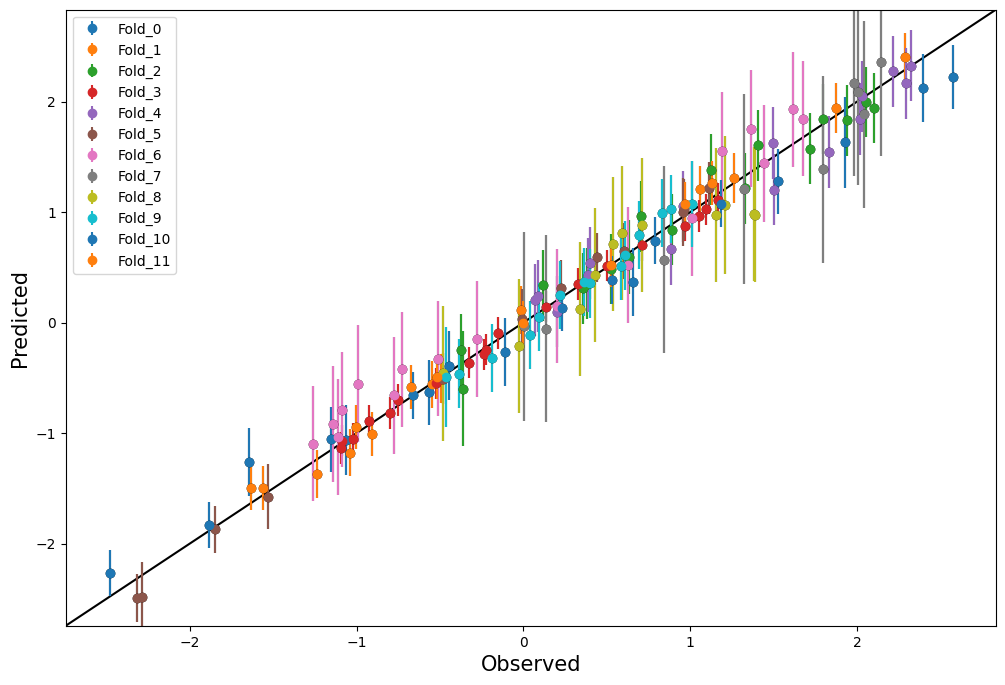

In [38]:
fig, ax = plt.subplots(figsize = (12, 8))

y_obs = Y_Train
y_pred_mean = y_obs - mean
y_pred_std = cov.diagonal()**0.5

ax.set_xlabel('Observed', fontsize = 15)
ax.set_ylabel('Predicted', fontsize = 15)

line_min = min(y_obs.min(), y_pred_mean.min())*1.1
line_max = max(y_obs.max(), y_pred_mean.max())*1.1
ax.plot([line_min, line_max], [line_min, line_max], 'k')
ax.set_xlim(line_min, line_max)
ax.set_ylim(line_min, line_max)

ax.errorbar(y_obs, y_pred_mean, yerr=2*y_pred_std, fmt='o', color = 'k')

for i in range(len(folds)):
    ax.errorbar(y_obs[folds[i]], y_pred_mean[folds[i]], yerr=2*y_pred_std[folds[i]], fmt='o', label = 'Fold_{}'.format(i))

ax.legend()

# Use the 'metrics.evaluate_GP()' function to compute a set of relevant evaluation metrics

In [39]:
metrics = gp_metrics.evaluate_GP(K.numpy(), Y_Train.numpy(), folds, noise_variance = 0) 

for key in ['log_marginal_likelihood', 'log_pseudo_likelihood', 'MSE']:
    print(key, metrics[key])

log_marginal_likelihood 77.63160568613355
log_pseudo_likelihood -211.50612276630835
MSE 0.02547900224863503


In [40]:
%timeit gp_metrics.evaluate_GP(K.numpy(), Y_Train.numpy(), folds, noise_variance = 0) 

5.74 ms ± 71.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# LOO for the same data (not correct)

In [41]:
metrics = gp_metrics.evaluate_GP(K.numpy(), Y_Train.numpy(), folds = None, noise_variance = 0) 

for key in ['log_marginal_likelihood', 'log_pseudo_likelihood', 'MSE']:
    print(key, metrics[key])

log_marginal_likelihood 77.63160568613355
log_pseudo_likelihood -211.50612276630818
MSE 0.004262421159233205


In [42]:
# To compute the LOO residuals we only need the covariance matrix and the training observations (converted to numpy arrays)
mean, cov, residuals_transformed = gp_cv.loo(K.numpy(), Y_Train.numpy(), noise_variance = 0) 

# 'residuals_transformed' is the residuals transformed to the standard normal space
# we will see that this is not the same normalizing the individual residuals (which will remain correlated)
residuals_scaled = mean / cov.diagonal()**0.5

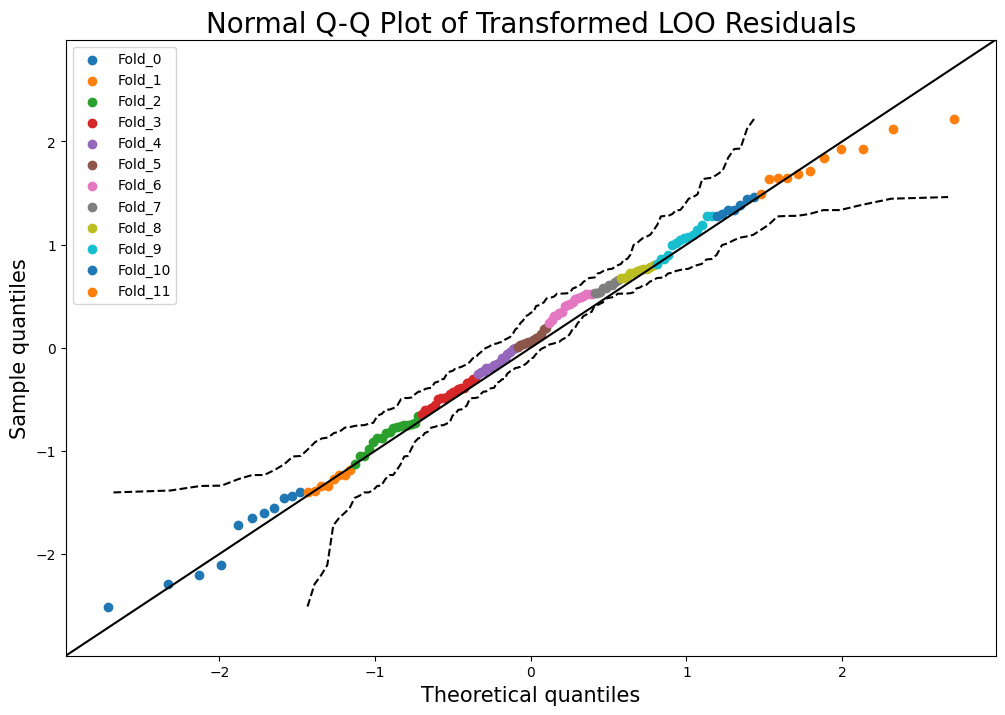

In [43]:
# Color by each fold 
fig, ax = plt.subplots(figsize = (12, 8))

q_sample, q_snorm, q_snorm_upper, q_snorm_lower = snorm_qq(residuals_transformed)
ax.plot(q_snorm_upper, q_sample, 'k--')
ax.plot(q_snorm_lower, q_sample, 'k--')
ax.set_xlabel('Theoretical quantiles', fontsize = 15)
ax.set_ylabel('Sample quantiles', fontsize = 15)
ax.set_title('Normal Q-Q Plot of Transformed LOO Residuals', fontsize = 20)
line_min = min(q_snorm.min(), q_sample.min())*1.1
line_max = max(q_snorm.max(), q_sample.max())*1.1
ax.plot([line_min, line_max], [line_min, line_max], 'k')
ax.set_xlim(line_min, line_max)
ax.set_ylim(line_min, line_max)

for i in range(len(folds)):
    ax.scatter(q_snorm[folds[i]], q_sample[folds[i]], marker = 'o', label = 'Fold_{}'.format(i))

ax.legend()

In [44]:
mean_multi, cov_multi, residuals_transformed_multi = gp_cv.multifold(K.numpy(), Y_Train.numpy(), folds, noise_variance = 0) 
residuals_scaled_multi = mean_multi / cov_multi.diagonal()**0.5
mean_loo, cov_loo, residuals_transformed_loo = gp_cv.loo(K.numpy(), Y_Train.numpy(), noise_variance = 0) 
residuals_scaled_loo = mean_loo / cov_loo.diagonal()**0.5


In [45]:
residuals_transformed_loo - residuals_transformed_multi
mean_multi - mean_loo
cov_multi - cov_loo
residuals_scaled_multi - residuals_scaled_loo

array([ 0.63828647,  1.97021417,  0.90474602,  2.61995132,  0.64121436,
        0.88393032,  0.3993844 , -1.19398898,  0.41323953, -1.52547732,
       -0.23671261, -0.41346716, -0.76148484, -0.87818525, -0.45952886,
        0.09106196,  0.52497894,  0.45746516,  0.61232268,  0.00625138,
        0.41053269,  0.08326096,  0.21615487,  0.60959735,  0.68132189,
        0.03210704,  2.1418195 , -0.71891332,  1.45296895, -1.25958443,
       -0.37993765, -1.88052488, -1.07038453, -1.94223803,  0.33082003,
       -0.82077007,  0.73711326,  0.63114166,  1.9602798 , -0.55857026,
        1.71474127, -1.15434042,  1.2949096 , -2.28133249,  1.54644476,
       -0.83679099,  0.7886117 ,  0.06233673,  0.81103581, -0.1412679 ,
        1.09385506, -0.79954511,  0.85128845, -1.17349686,  0.12515852,
       -0.97103843, -0.10168241, -1.39644349,  0.02410239, -2.07330342,
        1.31327004, -2.11928624,  0.74336961,  0.26864695, -0.23996346,
        2.11487054,  0.87260617,  1.91103928,  0.96297631,  1.10

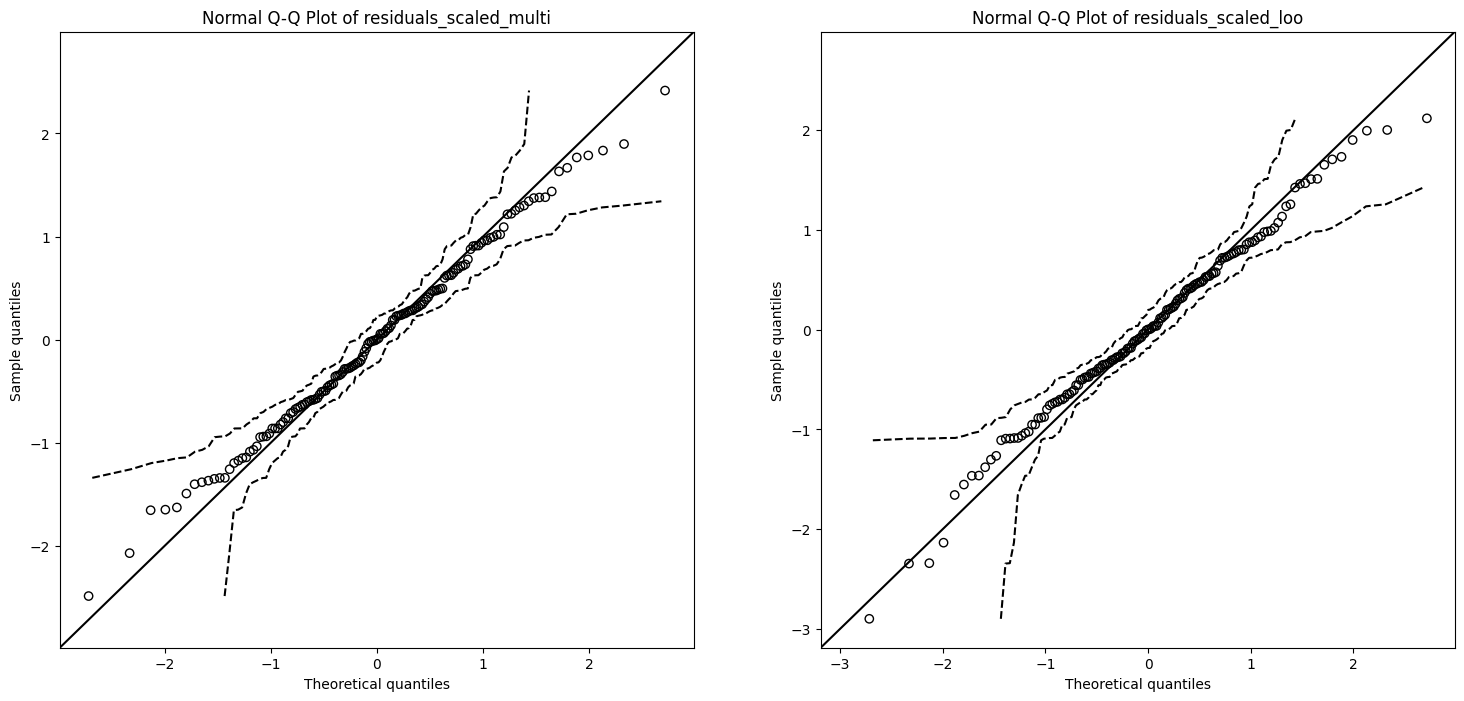

In [46]:
# Plot residuals 
fig, axs = plt.subplots(ncols = 2, figsize = (18, 8))
axs = axs.ravel()

plotres(axs[0], residuals_scaled_multi, 'residuals_scaled_multi')
plotres(axs[1], residuals_scaled_loo, 'residuals_scaled_loo')